## Python Workshop: Part 2

Welcome! This is part 2 of 2 of our intro to Python and Pandas.

In this notebook we will cover:
- Using APIs and API wrapper libraries to retrieve data
- Additional data visualizations with Seaborn
- Window functions and aggregations with Pandas
- Excel file I/O
- [Regular Expressions](https://docs.python.org/3/howto/regex.html)
- Decision Tree Learning with scikit-learn

We will be focusing on common data manipulation tasks in Pandas, this focuses on solutions without too many low-level details, so be sure to check out the [documentation](https://pandas.pydata.org/docs/index.html) if you want to learn more about the underlying functionality.

For additional visualization ideas, see the Seaborn [Gallery](https://seaborn.pydata.org/examples/index.html)

In [47]:
import os
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from sklearn.tree import DecisionTreeRegressor, plot_tree

### Getting data from an API with requests
We will be using [NYC Air Quality Data](https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data) accessed via an API endpoint.

The requests library is used to interact with APIs. API responses are typically in JSON, which is a similar format to a python dict.

The endpoint is an https address, followed by a set of filters after the "?". Here we are filtering to PM 2.5 pollution (indicator ID = 365) during Summer 2022.

In [48]:
# The URL is used to specify the endpoint and query parameters
api_url = "https://data.cityofnewyork.us/resource/c3uy-2p5r.json?indicator_id=365&geo_type_name=Borough"

# a GET request elicits a response from the server, in this case a series of data
result = requests.get(api_url)

In [49]:
type(result)

requests.models.Response

In [50]:
type(result.json())

list

In [51]:
type(result.json()[0])

dict

In [52]:
# let's check out the first result
result.json()[0]

{'unique_id': '179584',
 'indicator_id': '365',
 'name': 'Fine particles (PM 2.5)',
 'measure': 'Mean',
 'measure_info': 'mcg/m3',
 'geo_type_name': 'Borough',
 'geo_join_id': '2',
 'geo_place_name': 'Brooklyn',
 'time_period': 'Summer 2012',
 'start_date': '2012-06-01T00:00:00.000',
 'data_value': '10.4'}

In [53]:
# pd.DataFrame can parse a list of JSON items/dicts
aq = pd.DataFrame.from_records(result.json())
aq.head()

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,179584,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Summer 2012,2012-06-01T00:00:00.000,10.4
1,179589,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Summer 2013,2013-06-01T00:00:00.000,10.3
2,410725,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Annual Average 2016,2015-12-31T00:00:00.000,7.8
3,179590,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,3,Manhattan,Summer 2013,2013-06-01T00:00:00.000,11.8
4,742157,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,4,Queens,Summer 2021,2021-06-01T00:00:00.000,8.1


In [54]:
# what time periods are in this dataset?
aq.time_period.unique()

array(['Summer 2012', 'Summer 2013', 'Annual Average 2016', 'Summer 2021',
       'Annual Average 2021', 'Winter 2020-21', 'Summer 2011',
       'Summer 2010', 'Summer 2016', 'Annual Average 2017',
       'Annual Average 2011', 'Winter 2010-11', 'Summer 2009',
       'Annual Average 2013', 'Annual Average 2009', 'Winter 2018-19',
       'Winter 2021-22', 'Winter 2015-16', 'Annual Average 2012',
       'Summer 2015', 'Summer 2019', 'Winter 2014-15',
       'Annual Average 2015', 'Winter 2012-13', 'Winter 2017-18',
       'Annual Average 2018', 'Annual Average 2010', 'Winter 2019-20',
       'Winter 2009-10', 'Winter 2016-17', 'Winter 2011-12',
       'Summer 2014', 'Annual Average 2020', 'Summer 2017', 'Summer 2018',
       'Annual Average 2014', 'Summer 2022', 'Winter 2013-14',
       'Annual Average 2019', 'Summer 2020', 'Winter 2008-09',
       'Annual Average 2022'], dtype=object)

In [55]:
# drop annual from data so we can look at seasonal trends (we are using the NOT operator "~" instead of df.drop)
aq = aq[~aq.time_period.str.startswith("Annual")]

In [56]:
# confirm we have borough-level data (not zip code or district)
aq.geo_type_name.unique()

array(['Borough'], dtype=object)

In [57]:
# note that all of the API columns read in as text, so we'll need to convert the numbers and datetime
aq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 0 to 207
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   unique_id       140 non-null    object
 1   indicator_id    140 non-null    object
 2   name            140 non-null    object
 3   measure         140 non-null    object
 4   measure_info    140 non-null    object
 5   geo_type_name   140 non-null    object
 6   geo_join_id     140 non-null    object
 7   geo_place_name  140 non-null    object
 8   time_period     140 non-null    object
 9   start_date      140 non-null    object
 10  data_value      140 non-null    object
dtypes: object(11)
memory usage: 13.1+ KB


In [58]:
# convert to numeric
aq["data_value"] = pd.to_numeric(aq.data_value)

# convert to datetime
aq["start_date"] = pd.to_datetime(aq.start_date)

<Axes: xlabel='data_value', ylabel='Count'>

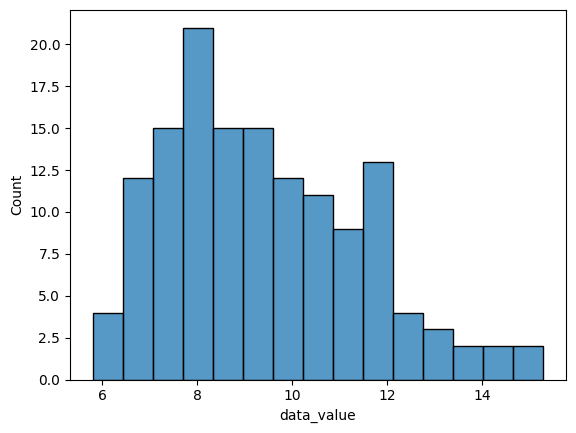

In [59]:
# let's check out the distribution of air quality values in the data set (high is bad)
sns.histplot(aq.data_value, bins=15)

<Axes: xlabel='start_date', ylabel='data_value'>

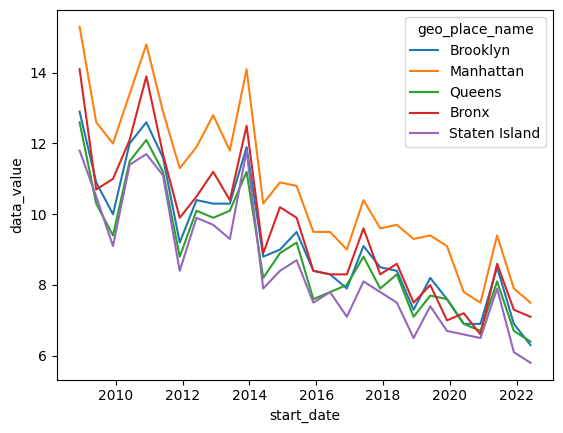

In [60]:
# plotting PM2.5 air pollution over time in each borough
sns.lineplot(data=aq, x="start_date", y="data_value", hue="geo_place_name")

### Using an API wrapper
Many APIs provide a wrapper, i.e. a library containing higher-level functions for easier access to the API. **yfinance** is the library for the Yahoo Finance API, which contains stock prices and other information on public companies.


In [61]:
# specify query parameters
ticker_list = ["AAPL", "MSFT", "NVDA", "SPY"]
start_date = "2024-01-01"
end_date = "2024-04-30"

stocks = yf.download(tickers=ticker_list, start=start_date, end=end_date, interval="1d")

[*********************100%%**********************]  4 of 4 completed


In [62]:
# see that we have a multi-indexed dataframe with multiple levels (Price, Ticker)
stocks.head()

Price        Adj Close                                           Close   
Ticker            AAPL        MSFT        NVDA         SPY        AAPL   
Date                                                                     
2024-01-02  185.152283  369.518921  481.657410  471.186005  185.639999  \
2024-01-03  183.765930  369.249908  475.667694  467.337982  184.250000   
2024-01-04  181.432098  366.599579  479.957489  465.832642  181.910004   
2024-01-05  180.703995  366.410278  490.946960  466.470673  181.179993   
2024-01-08  185.072495  373.325012  522.505493  473.129974  185.559998   

Price                                                 High              ...   
Ticker            MSFT        NVDA         SPY        AAPL        MSFT  ...   
Date                                                                    ...   
2024-01-02  370.869995  481.679993  472.649994  188.440002  375.899994  ...  \
2024-01-03  370.600006  475.690002  468.790009  185.880005  373.260010  ...   
2024-01-04  367.940002  479.980011  467.279999  183.089996  373.100006  ...   
2024-01-05  367.750000  490.970001  467.920013  182.759995  372.059998  ...   
2024-01-08  374.690002  522.530029  474.600006  185.600006  375.200012  ...   

Price              Low                    Open                           
Ticker            NVDA         SPY        AAPL        MSFT        NVDA   
Date                                                                     
2024-01-02  475.950012  470.489990  187.149994  373.859985  492.440002  \
2024-01-03  473.200012  468.170013  184.220001  369.010010  474.850006   
2024-01-04  475.079987  467.049988  182.149994  370.670013  477.670013   
2024-01-05  483.059998  466.429993  181.990005  368.970001  484.619995   
2024-01-08  494.790009  468.299988  182.089996  369.299988  495.119995   

Price                     Volume                                 
Ticker             SPY      AAPL      MSFT      NVDA        SPY  
Date                                                             
2024-01-02  472.160004  82488700  25258600  41125400  123623700  
2024-01-03  470.429993  58414500  23083500  32089600  103585900  
2024-01-04  468.299988  71983600  20901500  30653500   84232200  
2024-01-05  467.489990  62303300  20987000  41456800   86060800  
2024-01-08  468.429993  59144500  23134000  64251000   74879100  

[5 rows x 24 columns]

In [63]:
# let's select prices from the dataframe and melt to normalize the data
prices = stocks["Adj Close"].reset_index().melt(id_vars="Date")
prices.tail()

,Date,Ticker,value
323,2024-04-23,SPY,505.649994
324,2024-04-24,SPY,505.410004
325,2024-04-25,SPY,503.489990
326,2024-04-26,SPY,508.260010
327,2024-04-29,SPY,510.059998


<Axes: xlabel='Date', ylabel='value'>

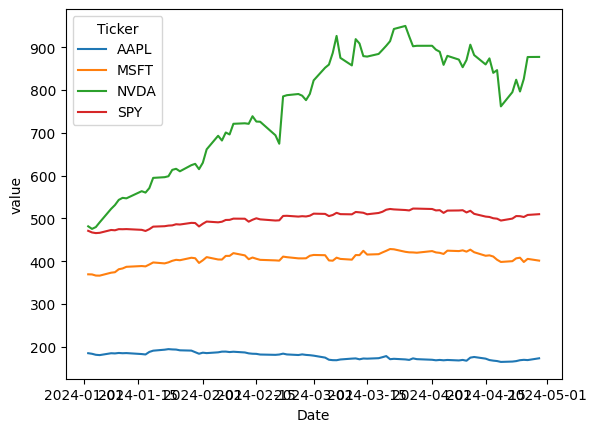

In [64]:
sns.lineplot(data=prices, x="Date", y="value", hue="Ticker" )

### Calculating Window functions

Window functions are functions applied to distinct groups of data, without the final aggregation step of the GroupBy. This means you end up with the same number of rows you started with. An example is ranking or a cumulative sum per group.

In Pandas, you still use GroupBy to do this, and the function you choose determines whether you aggregate the rows in the group or return a windowed value.

In [65]:
# we will calculate the daily percent change in price for each ticker symbol (ensure DF is sorted correctly!)
prices["daily_pct"] = (prices
                       .sort_values(["Ticker", "Date"])
                       .groupby("Ticker")["value"] # just pct change on the value column
                       .pct_change())

In [66]:
# using the daily percent changes, we can calculate the cumulative percent return
prices["pct_return"] = (prices
                        .groupby("Ticker")["daily_pct"]
                        .apply(lambda x: (1 + x).cumprod())
                        .droplevel(0)) # droplevel removes the multi-index so we get a single Series back

In [67]:
# now we have daily and cumulative percent returns for each stock
prices.head(10)

,Date,Ticker,value,daily_pct,pct_return
0,2024-01-02,AAPL,185.152283,NaN,NaN
1,2024-01-03,AAPL,183.765930,-0.007488,0.992512
2,2024-01-04,AAPL,181.432098,-0.012700,0.979907
3,2024-01-05,AAPL,180.703995,-0.004013,0.975975
4,2024-01-08,AAPL,185.072495,0.024175,0.999569
5,2024-01-09,AAPL,184.653595,-0.002263,0.997307
6,2024-01-10,AAPL,185.700851,0.005671,1.002963
7,2024-01-11,AAPL,185.102417,-0.003223,0.999731
8,2024-01-12,AAPL,185.431549,0.001778,1.001508
9,2024-01-16,AAPL,183.147568,-0.012317,0.989173


### Visualizing categorical and continuous data

With one categorical axis (ticker) and one continuous axis (price/change) we can use box-style and scatter-style plots to visualize the distribution of price changes for each ticker.

To plot the cumulative returns, we'll make a line plot of returns over time.

<Axes: xlabel='daily_pct', ylabel='Ticker'>

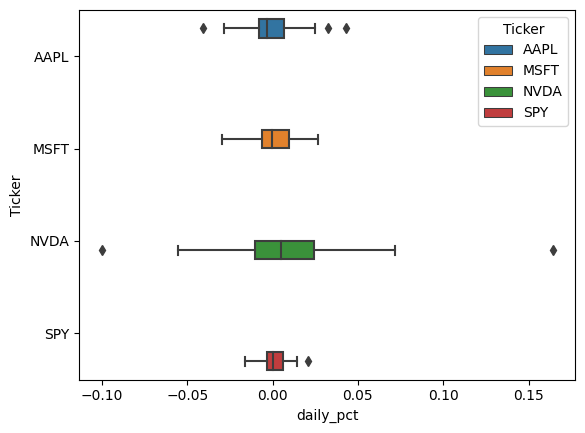

In [68]:
# let's look at the distribution of daily percent changes for each stock
sns.boxplot(data=prices, x="daily_pct", y="Ticker", hue="Ticker")

<Axes: xlabel='Date', ylabel='pct_return'>

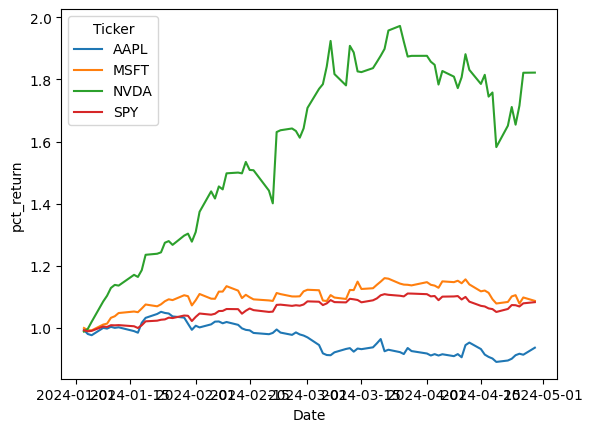

In [69]:
# let's make a plot to compare the percent returns
sns.lineplot(data=prices, x="Date", y="pct_return", hue="Ticker")

### Machine Learning (in 5 mins)

We will briefly show a demonstration of decision tree learning in Python with scikit-learn. We will use a decision tree to approximate a sine function, based on [this](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py) tutorial.

In [70]:
# Create a random dataset
rng = np.random.RandomState(1)
# generate 80 random numbers on [0,1], multiply by 5 and sort
X = np.sort(5 * rng.rand(80, 1), axis=0)
# create target function of sin(X)
y = np.sin(X).ravel() + rng.normal(0, 0.1, 80)
# add some noise to every 5th observation
# y[::5] +=

# Fit regression model, we will compare 2 different depths of tree
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# combine into dataframe
ml_df = pd.DataFrame()
ml_df["x"] = X_test.ravel()
ml_df["y_true"] = np.sin(X_test).ravel()
ml_df["y_1"] = y_1
ml_df["y_2"] = y_2

ml_df_melt = ml_df.melt(id_vars=["x"], var_name="series")

In [71]:
ml_df_melt.head()

,x,series,value
0,0.00,y_true,0.000000
1,0.01,y_true,0.010000
2,0.02,y_true,0.019999
3,0.03,y_true,0.029996
4,0.04,y_true,0.039989


[Text(0.5, 0.8333333333333334, 'x[0] <= 3.133\nsquared_error = 0.486\nsamples = 80\nvalue = 0.175'),
 Text(0.25, 0.5, 'x[0] <= 0.443\nsquared_error = 0.091\nsamples = 51\nvalue = 0.648'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.015\nsamples = 8\nvalue = 0.209'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.063\nsamples = 43\nvalue = 0.729'),
 Text(0.75, 0.5, 'x[0] <= 3.975\nsquared_error = 0.095\nsamples = 29\nvalue = -0.657'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.018\nsamples = 15\nvalue = -0.388'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.017\nsamples = 14\nvalue = -0.945')]

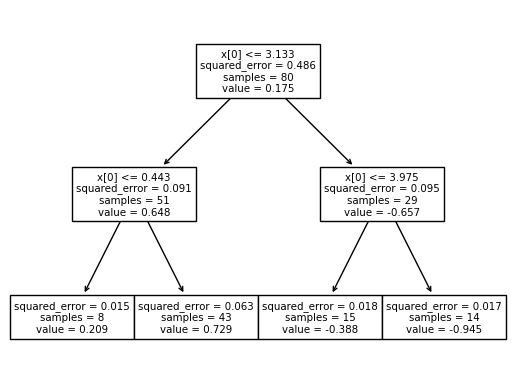

In [72]:
# let's plot the tree and learned rules
plot_tree(regr_1)

<Axes: xlabel='x', ylabel='value'>

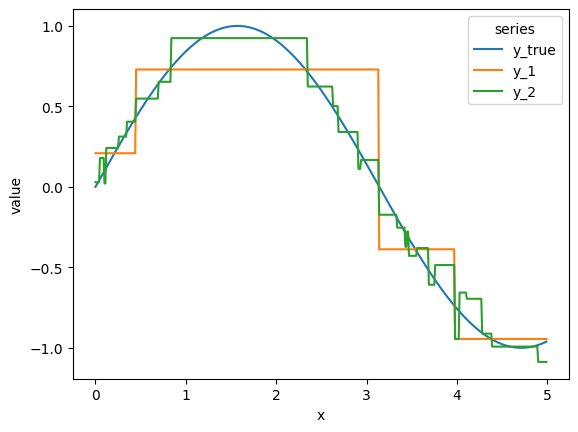

In [73]:
# let's compare the 2 fitted trees to the actual sine function
sns.lineplot(data=ml_df_melt, x="x", y="value", hue="series")